In [1]:
!pip install torchensemble

In [2]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import os, os.path
import numpy as np
import torch.optim as optim
from pathlib import Path
from torchvision import datasets, models, transforms

from torchensemble import VotingClassifier
from torchensemble.utils.logging import set_logger

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

In [3]:
if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [4]:
# Connecting and Mounting to the Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
def get_class_distribution(dataset_obj, idx2class):
    count_dict = {k:0 for k,v in dataset_obj.class_to_idx.items()}
    
    for element in dataset_obj:
        y_lbl = element[1]
        y_lbl = idx2class[y_lbl]
        count_dict[y_lbl] += 1
            
    return count_dict

In [6]:
def load_data(hieroglyph_directory_path, batch_size=20, num_workers=0):
    train_dir = os.path.join(hieroglyph_directory_path, 'train/')
    test_dir = os.path.join(hieroglyph_directory_path, 'test/')

    classes = []

    for filename in os.listdir(train_dir):
        if filename == '.DS_Store':
            pass
        else:
            classes.append(filename)

    classes.sort()

    # print("Our classes:", classes)
    # print(len(classes))

    data_transform = transforms.Compose([transforms.ToTensor(),
                                            transforms.RandomApply([transforms.RandomHorizontalFlip()]),
                                            transforms.RandomRotation(degrees=(-10, 10)),
                                            transforms.RandomAffine(degrees=0, translate=(.1, .1)),
                                            transforms.RandomApply([transforms.ColorJitter(brightness=(1, 1.2),
                                                                                            contrast=(1, 1.5),
                                                                                            saturation=(1, 1.5),
                                                                                            hue=(0, 0.5))]),
                                            transforms.RandomErasing(p=0.5, scale=(0.05, 0.05), ratio=(0.3, 3.3), value=0,
                                                                      inplace=False),
                                            transforms.Normalize((0.5,), (0.5,))])

    train_data = datasets.ImageFolder(train_dir, transform=data_transform)
    test_data = datasets.ImageFolder(test_dir, transform=data_transform)

    # print('Num training images: ', len(train_data))
    # print('Num test images: ', len(test_data))

    # WeightedRandomSampler for train loader
    idx2class = {v: k for k, v in train_data.class_to_idx.items()}

    target_list = torch.tensor(train_data.targets)
    class_count = [i for i in get_class_distribution(train_data, idx2class).values()]
    class_weights = 1./torch.tensor(class_count, dtype=torch.float) 
    class_weights_all = class_weights[target_list]
    weighted_sampler = torch.utils.data.WeightedRandomSampler(weights=class_weights_all, num_samples=len(class_weights_all), replacement=True)

    # prepare data loaders
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                               num_workers=num_workers, sampler=weighted_sampler, drop_last=True)
    
    # WeightedRandomSampler for test loader
    idx2class_test = {v: k for k, v in test_data.class_to_idx.items()}

    target_list_test = torch.tensor(test_data.targets)
    class_count_test = [i for i in get_class_distribution(test_data, idx2class_test).values()]
    class_weights_test = 1./torch.tensor(class_count_test, dtype=torch.float) 
    class_weights_all_test = class_weights_test[target_list_test]
    weighted_sampler_test = torch.utils.data.WeightedRandomSampler(weights=class_weights_all_test, num_samples=len(class_weights_all_test), replacement=True)

    test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
                                              num_workers=num_workers, sampler=weighted_sampler_test)

    return train_loader, test_loader, classes

In [7]:
data_dir = '/content/drive/MyDrive/EgyptianHieroglyphDataset_134/'

hieroglyph_for_train = []
file_count_list = []

for name in os.listdir('/content/drive/MyDrive/EgyptianHieroglyphDataset_134/train/'):
  path, dirs, files = next(os.walk("/content/drive/MyDrive/EgyptianHieroglyphDataset_134/train/"+name))
  file_count = len(files)
  print(name, file_count)
  file_count_list.append(file_count)
  hieroglyph_for_train.append(name)

hieroglyph_dict = dict(zip(hieroglyph_for_train, file_count_list))

Aa15 2
Aa26 4
Aa27 2
Z1 39
Z11 8
Z7 3
Y2 5
Y3 2
Y5 6
E34 97
E1 5
E23 8
E9 8
W18 5
W24 31
W11 4
W22 1
W19 3
W25 9
D21 146
D4 29
D46 40
D1 4
D36 47
D58 28
D2 19
D35 45
D60 4
D28 13
D10 2
D39 1
D56 2
D19 2
D52 4
D54 9
D156 2
X1 185
X8 4
U15 10
U28 2
U1 20
U33 13
U7 3
T28 1
T22 7
T21 2
T20 3
T30 2
V31 106
V28 28
V13 63
V4 10
V30 6
V7 4
V24 4
V6 1
R8 53
R4 2
Q3 61
Q1 13
Q7 2
P8 12
P6 2
P98 4
P1 4
S29 212
S34 8
S24 1
S28 1
O50 84
O49 10
O28 8
O34 15
O1 16
O31 5
O4 11
I9 116
I10 32
G17 156
L1 2
M17 291
M44 5
M42 4
M1 2
M12 2
M18 10
M195 2
M20 2
M23 30
M41 2
M3 3
M16 1
M8 1
M40 2
M29 2
H6 5
N35 358
N5 16
N1 14
N37 24
N14 11
N31 13
N17 6
N29 14
N18 15
N41 2
N30 9
N25 1
N36 1
F13 6
F16 5
F35 2
F34 8
F31 6
F4 3
F40 1
F18 4
F9 2
F26 3
G39 16
G43 157
G5 24
G40 6
G7 8
G35 30
G1 28
G21 1
G25 21
G36 7
G4 6
G14 1
G26 1
G29 2
G37 2


<BarContainer object of 134 artists>

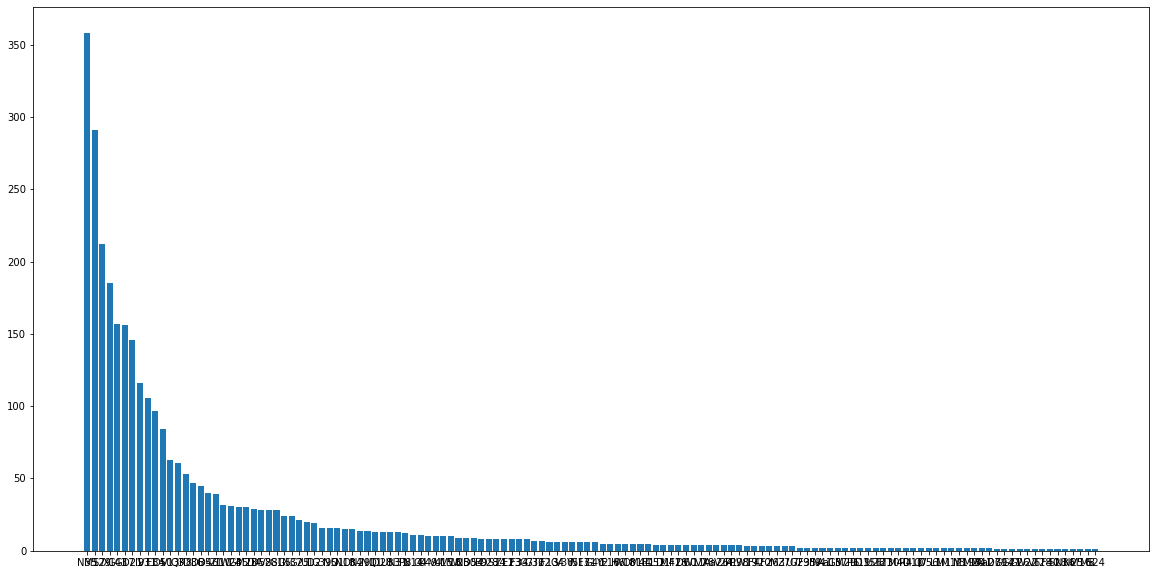

In [8]:
import matplotlib.pyplot as plt
import pandas as pd

df = pd.DataFrame({"Hieroglyph":hieroglyph_for_train, "Count":file_count_list})

df_sorted= df.sort_values('Count',ascending=False)

plt.figure(figsize=(20,10))
# make bar plot with matplotlib
plt.bar('Hieroglyph', 'Count',data=df_sorted)

In [9]:
# Number of images processed in a single training
batch_size = 20
num_workers = 0

# The load_data function is from hieroglyph_data_preparation python file
train_loader, test_loader, classes = load_data(data_dir)

In [ ]:
# Whether to extract features with the model
feature_extract = False

model_selection = "resnet-50"

# False if you want scratch model, True if you want pretrained model
whether_to_pretrain = True

# Load the model
if model_selection == "resnet-50":
    resnet50 = models.resnet50(pretrained=whether_to_pretrain)

# Number of features in the last layer of resnet
n_inputs = resnet50.fc.in_features

# Add last linear layer (n_inputs -> 40 hieroglyph classes)
# New layers automatically have requires_grad = True
last_layer = nn.Sequential(
                nn.Linear(n_inputs, len(classes)))

resnet50.fc = last_layer

# if GPU is available, move the model to GPU
if train_on_gpu:
    resnet50.cuda()

In [12]:
epochs = 10

# Define the ensemble
ensemble = VotingClassifier(
    estimator=resnet50,               # here is your deep learning model
    n_estimators=3,                        # number of base estimators
    cuda=True
)

# Set the optimizer
ensemble.set_optimizer(
    "Adam",                                 # type of parameter optimizer
    lr=1e-3,                       # learning rate of parameter optimizer
    weight_decay=5e-4,              # weight decay of parameter optimizer
)

# Set the learning rate scheduler
ensemble.set_scheduler(
    "CosineAnnealingLR",                    # type of learning rate scheduler
    T_max=epochs,                           # additional arguments on the scheduler
)

# Train the ensemble
ensemble.fit(
    train_loader,
    epochs=epochs,                          # number of training epochs
)

# Evaluate the ensemble
acc = ensemble.predict(test_loader)         # testing accuracy

Estimator: 000 | Epoch: 000 | Batch: 000 | Loss: 4.87594 | Correct: 0/20
Estimator: 000 | Epoch: 000 | Batch: 100 | Loss: 4.11115 | Correct: 0/20
Estimator: 001 | Epoch: 000 | Batch: 000 | Loss: 4.99940 | Correct: 1/20
Estimator: 001 | Epoch: 000 | Batch: 100 | Loss: 4.96798 | Correct: 0/20
Estimator: 002 | Epoch: 000 | Batch: 000 | Loss: 4.94050 | Correct: 0/20
Estimator: 002 | Epoch: 000 | Batch: 100 | Loss: 4.91137 | Correct: 1/20
Estimator: 000 | Epoch: 001 | Batch: 000 | Loss: 3.70306 | Correct: 4/20
Estimator: 000 | Epoch: 001 | Batch: 100 | Loss: 3.31236 | Correct: 2/20
Estimator: 001 | Epoch: 001 | Batch: 000 | Loss: 4.59641 | Correct: 0/20
Estimator: 001 | Epoch: 001 | Batch: 100 | Loss: 4.32559 | Correct: 0/20
Estimator: 002 | Epoch: 001 | Batch: 000 | Loss: 4.56380 | Correct: 0/20
Estimator: 002 | Epoch: 001 | Batch: 100 | Loss: 3.84820 | Correct: 2/20
Estimator: 000 | Epoch: 002 | Batch: 000 | Loss: 2.32794 | Correct: 6/20
Estimator: 000 | Epoch: 002 | Batch: 100 | Loss: 1.

ValueError: ignored

In [14]:
def test_model(classes, resnet50, test_loader, criterion):
    # track test loss
    test_loss = 0.0
    class_correct = list(0. for i in range(len(classes)))
    class_total = list(0. for i in range(len(classes)))

    resnet50.eval()  # eval mode

    labels = []
    predictions = []
    # iterate over test data
    for data, target in test_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = resnet50(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update  test loss
        test_loss += loss.item() * data.size(0)
        # convert output probabilities to predicted class
        _, pred = torch.max(output, 1)
        # compare predictions to true label
        correct_tensor = pred.eq(target.data.view_as(pred))
        correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
        # calculate test accuracy for each object class
        for i in range(len(target.data)):
            label = target.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1
        
        # Will be used for calculating Recall, Precision, and F1-score
        labels.extend(target.data.view_as(pred).tolist())
        predictions.extend(pred.tolist())


    # calculate avg test loss
    test_loss = test_loss / len(test_loader.dataset)
    print('Test Loss: {:.6f}\n'.format(test_loss))

    return test_loss, class_correct, class_total, labels, predictions

In [16]:
criterion = nn.CrossEntropyLoss()

In [17]:
test_loss, class_correct, class_total, labels, predictions = test_model(classes, ensemble, test_loader, criterion)

Test Loss: 4.319453



In [19]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

In [20]:
# Test accuracy for each hieroglyph
for i in range(len(classes)):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (classes[i], 100 * class_correct[i] / class_total[i], np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

# Total Test accuracy
print("\nAccuracy: {:.3%}".format(accuracy_score(labels, predictions)))
print("\nPrecision: {:.3%}".format(precision_score(labels, predictions, average = 'weighted')))
print("\nRecall: {:.3%}".format(recall_score(labels, predictions, average = 'weighted')))
print("\nF1-score: {:.3%}".format(f1_score(labels, predictions, average = 'weighted')))

Test Accuracy of  Aa15: 100% ( 4/ 4)
Test Accuracy of  Aa26: 80% ( 4/ 5)
Test Accuracy of  Aa27: 87% ( 7/ 8)
Test Accuracy of    D1: 77% ( 7/ 9)
Test Accuracy of   D10: 75% ( 3/ 4)
Test Accuracy of  D156: 50% ( 4/ 8)
Test Accuracy of   D19:  0% ( 0/ 3)
Test Accuracy of    D2: 100% ( 5/ 5)
Test Accuracy of   D21: 90% (10/11)
Test Accuracy of   D28: 50% ( 2/ 4)
Test Accuracy of   D35: 100% ( 7/ 7)
Test Accuracy of   D36: 100% ( 8/ 8)
Test Accuracy of   D39: 100% ( 7/ 7)
Test Accuracy of    D4: 100% (19/19)
Test Accuracy of   D46: 100% ( 7/ 7)
Test Accuracy of   D52: 100% ( 8/ 8)
Test Accuracy of   D54: 100% ( 8/ 8)
Test Accuracy of   D56: 100% ( 7/ 7)
Test Accuracy of   D58: 100% ( 7/ 7)
Test Accuracy of   D60: 100% ( 5/ 5)
Test Accuracy of    E1: 100% ( 5/ 5)
Test Accuracy of   E23: 100% ( 4/ 4)
Test Accuracy of   E34: 100% ( 5/ 5)
Test Accuracy of    E9: 66% ( 2/ 3)
Test Accuracy of   F13: 100% ( 7/ 7)
Test Accuracy of   F16: 92% (12/13)
Test Accuracy of   F18: 80% ( 4/ 5)
Test Accurac

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
